In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
import glob, dill, sys, os

import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
from matplotlib import rc
rc('text', usetex=True)

import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
import jax.random as random
from numpyro.infer import init_to_value

In [2]:
def model(x, y, xmin, xmax, xb_lower=3., xb_upper=30., xd_lower=1., xd_upper=100.):
    lnxmin, lnxmax = jnp.log(xmin), jnp.log(xmax)
    lnxmodel = numpyro.sample("lnxmodel", dist.Uniform(lnxmin, lnxmax), sample_shape=(len(x),))
    lnxsigma = numpyro.sample("lnxsigma", dist.HalfNormal(scale=0.1))
    numpyro.sample("obsx", dist.Normal(loc=lnxmodel, scale=lnxsigma), obs=jnp.log(x))
    xmodel = numpyro.deterministic("xmodel", jnp.exp(lnxmodel))
    xsigma = numpyro.deterministic("xsigma", jnp.exp(lnxsigma))

    power_short = numpyro.sample("power_short", dist.Normal(loc=0, scale=0.05))
    power_long = numpyro.sample("power_long", dist.Normal(loc=0, scale=5))
    lnp_break = numpyro.sample("lnp_break", dist.Uniform(jnp.log(xb_lower), jnp.log(xb_upper)))
    p_break = numpyro.deterministic("p_break", jnp.exp(lnp_break))
    R_break = numpyro.sample("R_break", dist.LogNormal(jnp.log(1e4), 1))

    def func(x, p_break, R_break):
        return jnp.where(x < p_break, R_break * (x/p_break)**power_short, R_break * (x/p_break)**power_long)

    rmodel = numpyro.deterministic("rmodel", func(xmodel, p_break, R_break))
    logrmodel = numpyro.deterministic("logrmodel", jnp.log(rmodel))
    logrsigma = numpyro.sample("logrsigma", dist.HalfNormal(scale=1.))
    numpyro.sample("obsy", dist.Normal(loc=logrmodel, scale=logrsigma), obs=jnp.log(y))

    xdense = numpyro.deterministic("xmodeldense", jnp.logspace(jnp.log(xd_lower), jnp.log(xd_upper), base=jnp.e))
    numpyro.deterministic("logrmodeldense", jnp.log(func(xdense, p_break, R_break)))

In [3]:
d = pd.read_csv("sample_clean.csv")

In [4]:
len(d)

4968

In [5]:
dt = 150
tbins = np.arange(4000, 6500, dt)

In [6]:
for i in range(len(tbins)-1):
    tl, tu = tbins[i], tbins[i+1]
    idx = (d.teff>tl) & (d.teff<tu) #& (d.logg>logg_threshold)
    pobs = np.array(d[idx].Prot)
    print (tl, tu, np.percentile(pobs, [5, 10, 50, 90, 95]))

4000 4150 [10.3922 12.4386 23.761  39.696  43.0758]
4150 4300 [11.8288 12.6654 24.729  37.2234 40.0704]
4300 4450 [10.594  11.9665 24.4655 39.6155 42.69  ]
4450 4600 [ 9.7415 11.6448 23.9705 36.13   39.4255]
4600 4750 [10.24125 11.2325  24.6135  36.5755  38.0495 ]
4750 4900 [ 8.2715  9.6345 21.698  34.1575 36.906 ]
4900 5050 [ 8.21695  9.3905  22.5985  32.1233  34.30365]
5050 5200 [ 7.65085  9.5017  23.0315  32.8349  35.06465]
5200 5350 [ 7.0075  8.0952 20.549  30.6942 32.5819]
5350 5500 [ 5.9175  7.5714 19.168  28.0618 29.5266]
5500 5650 [ 5.8566  7.3476 18.658  24.8798 26.189 ]
5650 5800 [ 4.334    6.0435  15.16    21.011   22.68275]
5800 5950 [ 3.354   4.8026 12.767  18.0342 19.6812]
5950 6100 [ 2.52105  4.3848  10.847   15.4933  20.06225]
6100 6250 [ 1.87675  2.7945   7.5405  12.623   16.266  ]
6250 6400 [ 1.4138  1.8466  4.907  14.6226 18.689 ]


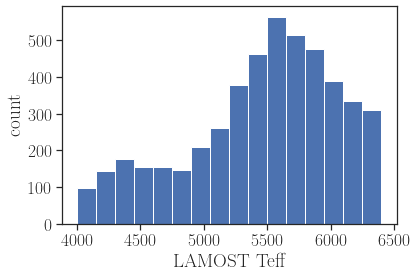

In [7]:
plt.xlabel("LAMOST Teff")
plt.ylabel("count")
plt.hist(d.teff, bins=tbins);

In [8]:
rnlabel = "variability amplitude $R_\mathrm{per}$\n normalized by Kepler photometric precision"
rlabel = "variability amplitude $R_\mathrm{per}$ (ppm)"
pnlabel = r"$\mathrm{Ro}=P_\mathrm{rot}/\tau_\mathrm{c}$"
dtlabel = 'empirical detection threshold'
tefflabel = 'LAMOST $T_\mathrm{eff}$ (K)'
protlabel = 'rotation period $P_\mathrm{rot}$ (days)'

## Fitting Rper vs Prot

In [119]:
resdir = 'plfit_results_t%d_pct/'%dt

In [120]:
resume = True*0

  0%|                                                                         | 0/3000 [00:00<?, ?it/s]

plfit_results_t150_pct/teff4000-4150
plfit_results_t150_pct/teff4150-4300
plfit_results_t150_pct/teff4300-4450
plfit_results_t150_pct/teff4450-4600
plfit_results_t150_pct/teff4600-4750
plfit_results_t150_pct/teff4750-4900
plfit_results_t150_pct/teff4900-5050
plfit_results_t150_pct/teff5050-5200
plfit_results_t150_pct/teff5200-5350
plfit_results_t150_pct/teff5350-5500
plfit_results_t150_pct/teff5500-5650
plfit_results_t150_pct/teff5650-5800
plfit_results_t150_pct/teff5800-5950
plfit_results_t150_pct/teff5950-6100
plfit_results_t150_pct/teff6100-6250
1.87675 16.266


sample: 100%|██████████| 3000/3000 [00:09<00:00, 308.74it/s, 31 steps of size 6.46e-02. acc. prob=0.93]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break   7810.75    604.35   7780.25   6733.82   8718.02   1053.82      1.00
    lnp_break      1.44      0.07      1.44      1.31      1.55     44.56      1.04
  lnxmodel[0]      1.71      0.08      1.72      1.62      1.83   3698.57      1.00
  lnxmodel[1]      2.19      0.07      2.20      2.09      2.30     83.70      1.03
  lnxmodel[2]      2.10      0.10      2.07      1.99      2.24     20.48      1.08
  lnxmodel[3]      1.39      0.08      1.39      1.28      1.50   2475.22      1.00
  lnxmodel[4]      1.85      0.08      1.83      1.72      1.97     30.50      1.06
  lnxmodel[5]      2.14      0.07      2.15      2.04      2.24     48.35      1.04
  lnxmodel[6]      2.02      0.08      2.04      1.92      2.13     29.27      1.06
  lnxmodel[7]      2.16      0.07      2.15      2.05      2.26    143.59      1.01
  lnxmodel[8]      1.46      0.08      1.45      1.33      1.56   1936.73  

plfit_results_t150_pct/teff6250-6400


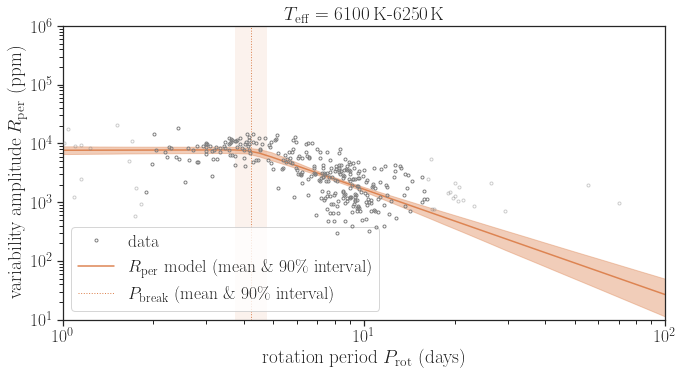

In [121]:
for i in range(len(tbins)-1):
    tl, tu = tbins[i], tbins[i+1]
    outname = resdir+"teff%d-%d"%(tl, tu)
    print (outname)    
    
    if tl!=6100:
        continue
    else:
        outname += "_beta"

    idx = (d.teff>tl) & (d.teff<tu) #& (d.logg>logg_threshold)
    pmin, pmax = np.percentile(d[idx].Prot, [5, 95])
    print (pmin, pmax)
    #pmin, pmax = 1., 100.
    
    idxp = (pmin<d.Prot) & (d.Prot<pmax)
    pobs, robs = jnp.array(d[idx&idxp].Prot), jnp.array(d[idx&idxp].Rper)
    pobs_out, robs_out = d[idx&(~idxp)].Prot, d[idx&(~idxp)].Rper
    
    filename = outname + "_mcmc.pkl"
    if os.path.exists(filename) and resume:
        mcmc = dill.load(open(filename, 'rb'))  
        mcmc.print_summary()
    else:   
        init_strategy = init_to_value(values={"lnxmodel": jnp.log(pobs)})
        kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)
        nw, ns = 5000//5, 10000//5
        mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
        rng_key = random.PRNGKey(0)
        mcmc.run(rng_key, pobs, robs, pmin, pmax, xb_lower=np.fmax(pmin, 3.), xb_upper=np.fmin(pmax, 30.))
        mcmc.print_summary()
        with open(outname+"_mcmc.pkl", "wb") as f:
            dill.dump(mcmc, f)

    samples = mcmc.get_samples()

    pmod = jnp.mean(samples['xmodeldense'], axis=0)
    rmean = jnp.exp(jnp.mean(samples['logrmodeldense'], axis=0))
    r5, r95 = jnp.exp(jnp.percentile(samples['logrmodeldense'], q=jnp.array([5, 95]), axis=0))
    rsigmamean = jnp.mean(jnp.exp(samples['logrsigma']))
    pb, pbsd = jnp.mean(samples['p_break']), jnp.std(samples['p_break'])
    pb5, pb95 = jnp.percentile(samples['p_break'], q=jnp.array([5,95]))

    plt.figure(figsize=(12*0.9,6*0.9))
    plt.title("$T_\mathrm{eff}=%d\,\mathrm{K}$-$%d\,\mathrm{K}$"%(tl, tu))
    plt.ylim(1e1, 1e6)
    plt.xlim(1, 100)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(rlabel)
    plt.xlabel(protlabel)
    plt.plot(pobs, robs, '.', color='gray', mfc='none', mew=1, zorder=1000, label='data')
    plt.plot(pobs_out, robs_out, '.', color='gray', mfc='none', mew=1, zorder=1000, alpha=0.4)
    plt.plot(pmod, rmean, '-', color='C1', label='$R_\mathrm{per}$ model (mean \& 90\% interval)')
    plt.axvline(x=pb, color='C1', ls='dotted', lw=1, label='$P_\mathrm{break}$ (mean \& 90\% interval)')
                #label='$P_\mathrm{break}=%.1f\pm%.1f\,\mathrm{days}$'%(pb, pbsd), )
    plt.fill_betweenx(np.logspace(1,6,100), x1=pb5, x2=pb95, color='C1', lw=0, alpha=0.1)
    plt.fill_between(pmod, r5, r95, alpha=0.4, color='C1')
    plt.legend(loc='lower left')
    plt.savefig(outname+"_model.png", dpi=200, bbox_inches="tight")

    #keys = ["R_break", "p_break", "power_long", "power_short", "logrsigma"]
    #labels = ['Rb', 'Pb', 'pl', 'ps', 'logrsigma']
    #hyper = pd.DataFrame(data=dict(zip(keys, [samples[k] for k in keys])))
    #fig = corner.corner(hyper, labels=labels, show_titles="%.2f")
    #plt.savefig(outname+"_corner.png", dpi=200, bbox_inches="tight")

## Fitting Rper vs Ro

In [122]:
resdir = 'plfitro_results_t%d_pct/'%dt

In [123]:
resdir
resume = True * 0

  0%|                                                                         | 0/2000 [00:00<?, ?it/s]

plfitro_results_t150_pct/teff4000-4150
plfitro_results_t150_pct/teff4150-4300
plfitro_results_t150_pct/teff4300-4450
plfitro_results_t150_pct/teff4450-4600
plfitro_results_t150_pct/teff4600-4750
plfitro_results_t150_pct/teff4750-4900
plfitro_results_t150_pct/teff4900-5050
plfitro_results_t150_pct/teff5050-5200
plfitro_results_t150_pct/teff5200-5350
plfitro_results_t150_pct/teff5350-5500
plfitro_results_t150_pct/teff5500-5650
plfitro_results_t150_pct/teff5650-5800
plfitro_results_t150_pct/teff5800-5950
plfitro_results_t150_pct/teff5950-6100
plfitro_results_t150_pct/teff6100-6250
0.33601758723731345 2.596413878837754


sample: 100%|█████████| 2000/2000 [00:08<00:00, 227.55it/s, 255 steps of size 6.17e-02. acc. prob=0.96]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break   7804.08    513.38   7778.51   6900.70   8555.62    919.88      1.00
    lnp_break     -0.23      0.05     -0.24     -0.31     -0.15    356.71      1.00
  lnxmodel[0]     -0.01      0.07     -0.01     -0.12      0.09   1431.05      1.00
  lnxmodel[1]      0.33      0.06      0.34      0.22      0.43   1064.03      1.00
  lnxmodel[2]      0.40      0.07      0.39      0.29      0.51     79.15      1.02
  lnxmodel[3]     -0.56      0.07     -0.56     -0.67     -0.46   1110.37      1.00
  lnxmodel[4]      0.11      0.07      0.10      0.01      0.22     91.16      1.02
  lnxmodel[5]      0.28      0.06      0.29      0.18      0.38    334.98      1.01
  lnxmodel[6]      0.08      0.07      0.09     -0.02      0.19    519.84      1.01
  lnxmodel[7]      0.28      0.06      0.27      0.17      0.39    356.65      1.01
  lnxmodel[8]     -0.13      0.07     -0.13     -0.23     -0.00   1356.08  

plfitro_results_t150_pct/teff6250-6400


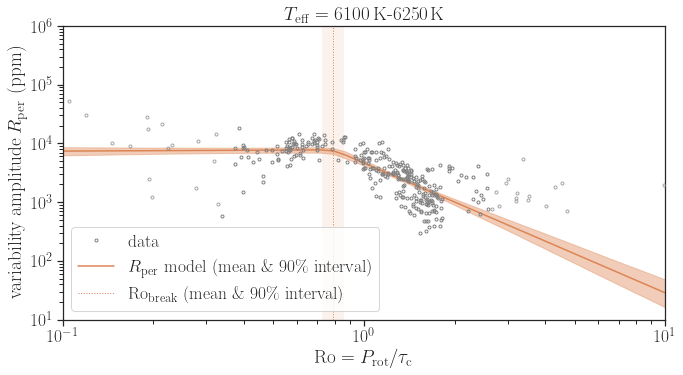

In [125]:
for i in range(len(tbins)-1):
    tl, tu = tbins[i], tbins[i+1]
    outname = resdir+"teff%d-%d"%(tl, tu)
    print (outname)    
    
    if tl!=6100:
        continue
    else:
        outname += "_beta"

    idx = (d.teff>tl) & (d.teff<tu) #& (d.logg>logg_threshold)
    pmin, pmax = np.percentile(d[idx].Pnorm, [5, 95])
    print (pmin, pmax)
    
    idxp = (pmin<d.Pnorm) & (d.Pnorm<pmax)
    pobs, robs = jnp.array(d[idx&idxp].Pnorm), jnp.array(d[idx&idxp].Rper)
    pobs_out, robs_out = d[idx&(~idxp)].Pnorm, d[idx&(~idxp)].Rper
    
    filename = outname + "_mcmc.pkl"
    if os.path.exists(filename) and resume:
        mcmc = dill.load(open(filename, 'rb'))   
        mcmc.print_summary()
    else:   
        init_strategy = init_to_value(values={"lnxmodel": jnp.log(pobs)})
        kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)
        nw, ns = 1000, 5000//5
        mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
        rng_key = random.PRNGKey(0)
        mcmc.run(rng_key, pobs, robs, pmin, pmax, #xb_lower=0.5, xb_upper=2., 
                 xb_lower=np.fmax(pmin, 0.5), xb_upper=np.fmin(pmax, 2.), 
                 xd_lower=0.1, xd_upper=10, extra_fields=('potential_energy',))
        mcmc.print_summary()
        with open(outname+"_mcmc.pkl", "wb") as f:
            dill.dump(mcmc, f)

    samples = mcmc.get_samples()

    pmod = jnp.mean(samples['xmodeldense'], axis=0)
    rmean = jnp.exp(jnp.mean(samples['logrmodeldense'], axis=0))
    r5, r95 = jnp.exp(jnp.percentile(samples['logrmodeldense'], q=jnp.array([5, 95]), axis=0))
    rsigmamean = jnp.mean(jnp.exp(samples['logrsigma']))
    pb, pbsd = jnp.mean(samples['p_break']), jnp.std(samples['p_break'])
    pb5, pb95 = jnp.percentile(samples['p_break'], q=jnp.array([5,95]))

    plt.figure(figsize=(12*0.9,6*0.9))
    plt.title("$T_\mathrm{eff}=%d\,\mathrm{K}$-$%d\,\mathrm{K}$"%(tl, tu))
    plt.ylim(1e1, 1e6)
    plt.xlim(0.1, 10)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(rlabel)
    plt.xlabel(pnlabel)
    #idxd = (pobs>pmin) & (pobs<pmax)
    if tu-tl>1000:
        mew=0.5
        plt.plot(pobs, robs, '.', color='gray', markersize=1, zorder=1000, alpha=0.8, label='data')
        plt.plot(pobs_out, robs_out, '.', color='gray', markersize=1, zorder=1000, alpha=0.4)
    else:
        mew=1.
        plt.plot(pobs, robs, '.', color='gray', mfc='none', mew=mew, zorder=1000, label='data')
        plt.plot(pobs_out, robs_out, '.', color='gray', mfc='none', mew=mew, zorder=1000, alpha=0.7)
    plt.plot(pmod, rmean, '-', color='C1', label='$R_\mathrm{per}$ model (mean \& 90\% interval)')
    plt.axvline(x=pb, color='C1', ls='dotted', lw=1, label='$\mathrm{Ro}_\mathrm{break}$ (mean \& 90\% interval)')
    plt.fill_betweenx(np.logspace(1,6,100), x1=pb5, x2=pb95, color='C1', lw=0, alpha=0.1)
    plt.fill_between(pmod, r5, r95, alpha=0.4, color='C1')
    plt.legend(loc='lower left')
    plt.savefig(outname+"_romodel.png", dpi=200, bbox_inches="tight")

In [11]:
resdir = 'plfitro_results_t%d_pct/'%dt

In [12]:
tbins_all = np.array([4000, 6250])
resume = True

In [13]:
resdir

'plfitro_results_t150_pct/'

plfitro_results_t150_pct/teff4000-6250
0.3278715297594667 1.6643812046887563

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      R_break   9758.19    657.13   9715.04   8707.25  10842.87    782.80      1.00
    lnp_break     -0.01      0.05     -0.01     -0.09      0.06    659.85      1.00
  lnxmodel[0]      0.00      0.01      0.00     -0.02      0.02   9127.81      1.00
  lnxmodel[1]      0.16      0.01      0.16      0.14      0.17   9567.61      1.00
  lnxmodel[2]     -0.38      0.01     -0.38     -0.40     -0.36   9629.74      1.00
  lnxmodel[3]      0.43      0.01      0.43      0.42      0.45   8555.91      1.00
  lnxmodel[4]      0.43      0.01      0.43      0.41      0.44   7268.96      1.00
  lnxmodel[5]     -0.53      0.01     -0.53     -0.55     -0.51   9184.05      1.00
  lnxmodel[6]      0.22      0.01      0.22      0.21      0.24   6013.52      1.00
  lnxmodel[7]      0.42      0.01      0.42      0.40      0.44   6165.24      1.0

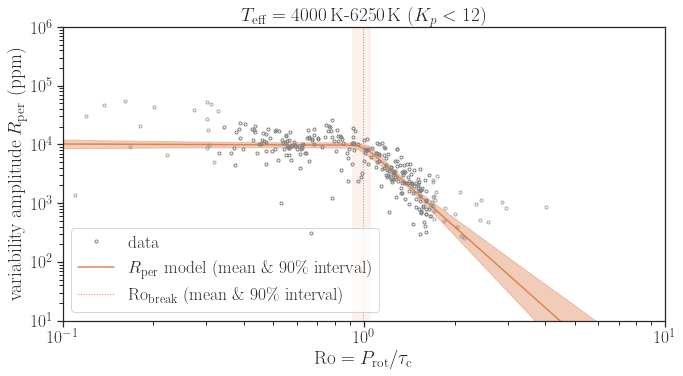

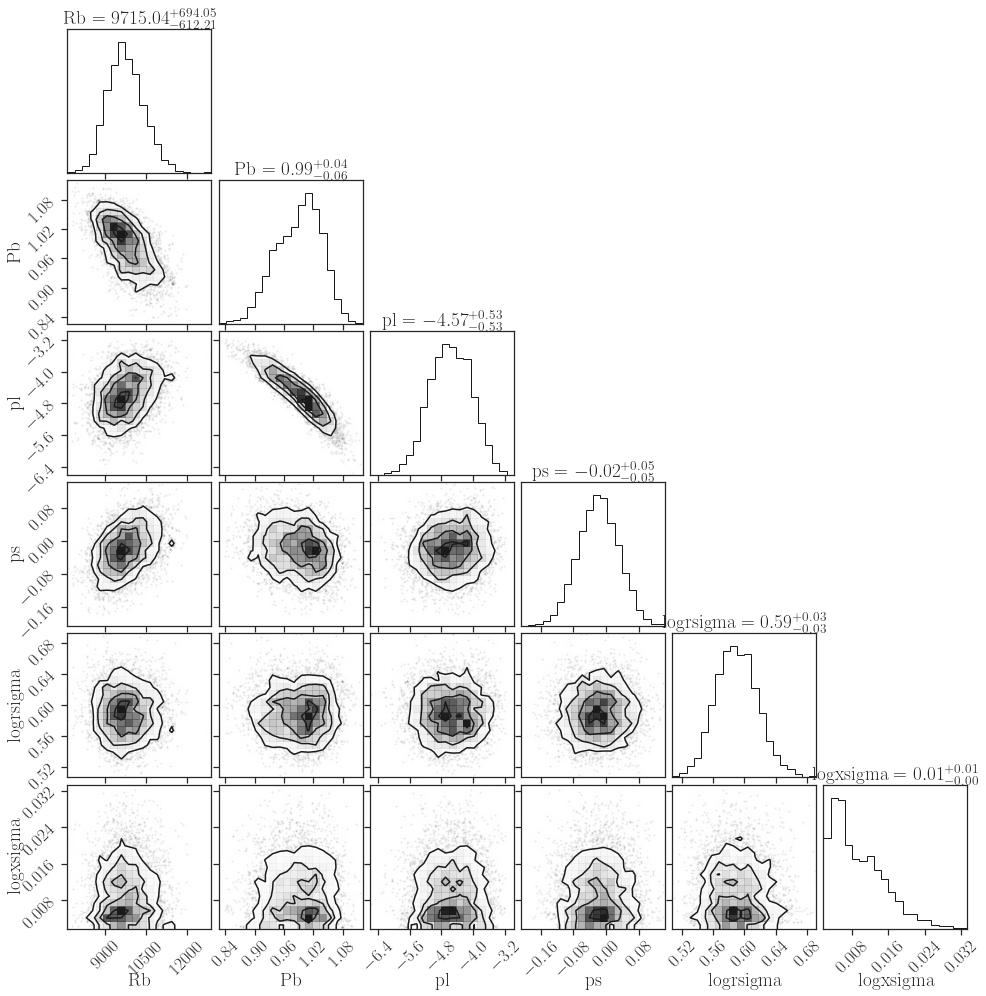

In [14]:
for i in range(len(tbins_all)-1):
    tl, tu = tbins_all[i], tbins_all[i+1]
    outname = resdir+"teff%d-%d"%(tl, tu)
    print (outname)    

    idx = (d.teff>tl) & (d.teff<tu) #& (d.logg>logg_threshold)
    pmin, pmax = np.percentile(d[idx].Pnorm, [5, 95])
    print (pmin, pmax)
    
    idx &= (d.kepmag < 12)
    outname += "_kp12"
    
    idxp = (pmin<d.Pnorm) & (d.Pnorm<pmax)
    pobs, robs = jnp.array(d[idx&idxp].Pnorm), jnp.array(d[idx&idxp].Rper)
    pobs_out, robs_out = d[idx&(~idxp)].Pnorm, d[idx&(~idxp)].Rper
    
    filename = outname + "_mcmc.pkl"
    if os.path.exists(filename) and resume:
        mcmc = dill.load(open(filename, 'rb'))   
        mcmc.print_summary()
    else:   
        init_strategy = init_to_value(values={"lnxmodel": jnp.log(pobs)})
        kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)
        nw, ns = 1000, 5000
        mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
        rng_key = random.PRNGKey(0)
        mcmc.run(rng_key, pobs, robs, pmin, pmax, #xb_lower=0.5, xb_upper=2., 
                 xb_lower=np.fmax(pmin, 0.5), xb_upper=np.fmin(pmax, 2.), 
                 xd_lower=0.1, xd_upper=10, extra_fields=('potential_energy',))
        mcmc.print_summary()
        with open(outname+"_mcmc.pkl", "wb") as f:
            dill.dump(mcmc, f)

    samples = mcmc.get_samples()

    pmod = jnp.mean(samples['xmodeldense'], axis=0)
    rmean = jnp.exp(jnp.mean(samples['logrmodeldense'], axis=0))
    r5, r95 = jnp.exp(jnp.percentile(samples['logrmodeldense'], q=jnp.array([5, 95]), axis=0))
    rsigmamean = jnp.mean(jnp.exp(samples['logrsigma']))
    pb, pbsd = jnp.mean(samples['p_break']), jnp.std(samples['p_break'])
    pb5, pb95 = jnp.percentile(samples['p_break'], q=jnp.array([5,95]))

    plt.figure(figsize=(12*0.9,6*0.9))
    if 'kp12' in outname:
        plt.title("$T_\mathrm{eff}=%d\,\mathrm{K}$-$%d\,\mathrm{K}$ ($K_p<12$)"%(tl, tu))
    else:
        plt.title("$T_\mathrm{eff}=%d\,\mathrm{K}$-$%d\,\mathrm{K}$"%(tl, tu))
    plt.ylim(1e1, 1e6)
    plt.xlim(0.1, 10)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(rlabel)
    plt.xlabel(pnlabel)
    #idxd = (pobs>pmin) & (pobs<pmax)
    if tu-tl>1000 and len(pobs)>300:
        mew=0.5
        plt.plot(pobs, robs, '.', color='gray', markersize=1, zorder=1000, alpha=0.8, label='data')
        plt.plot(pobs_out, robs_out, '.', color='gray', markersize=1, zorder=1000, alpha=0.4)
    else:
        mew=1.
        plt.plot(pobs, robs, '.', color='gray', mfc='none', mew=mew, zorder=1000, label='data')
        plt.plot(pobs_out, robs_out, '.', color='gray', mfc='none', mew=mew, zorder=1000, alpha=0.7)
    plt.plot(pmod, rmean, '-', color='C1', label='$R_\mathrm{per}$ model (mean \& 90\% interval)')
    plt.axvline(x=pb, color='C1', ls='dotted', lw=1, label='$\mathrm{Ro}_\mathrm{break}$ (mean \& 90\% interval)')
    plt.fill_betweenx(np.logspace(1,6,100), x1=pb5, x2=pb95, color='C1', lw=0, alpha=0.1)
    plt.fill_between(pmod, r5, r95, alpha=0.4, color='C1')
    plt.legend(loc='lower left')
    plt.savefig(outname+"_romodel.png", dpi=200, bbox_inches="tight")
    
    keys = ["R_break", "p_break", "power_long", "power_short", "logrsigma", "lnxsigma"]
    labels = ['Rb', 'Pb', 'pl', 'ps', 'logrsigma', 'logxsigma']
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k] for k in keys])))
    fig = corner.corner(hyper, labels=labels, show_titles="%.2f")
    plt.savefig(outname+"_corner.png", dpi=200, bbox_inches="tight")

## residual

In [15]:
res = np.array(np.log10(robs) - jnp.mean(np.log10(samples['rmodel']), axis=0))

In [16]:
rnds = np.random.randn(int(1e7))*np.mean(samples['logrsigma'])*np.log10(np.e)

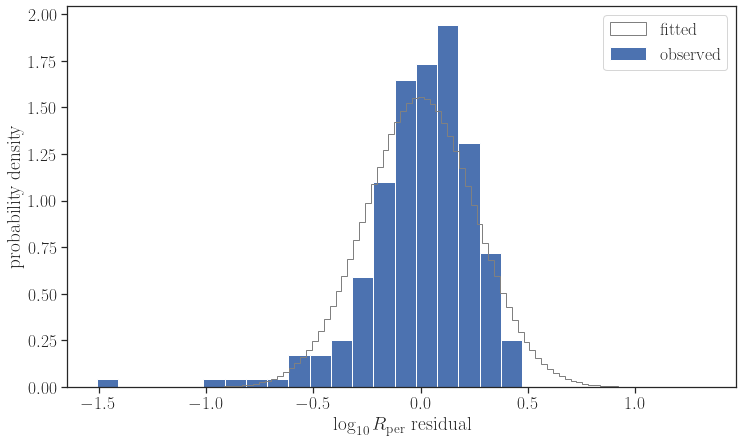

In [18]:
plt.figure(figsize=(12,7))
plt.xlabel("$\log_{10} R_\mathrm{per}$ residual")
plt.ylabel("probability density")
plt.hist(rnds, bins=100, density=True, histtype='step', lw=1, color='gray', label='fitted')
plt.hist(res, bins=20, density=True, label='observed')
plt.legend(loc='best')